First, let's load the JSON file which describes the human pose task.  This is in COCO format, it is the category descriptor pulled from the annotations file.  We modify the COCO category slightly, to add a neck keypoint.  We will use this task description JSON to create a topology tensor, which is an intermediate data structure that describes the part linkages, as well as which channels in the part affinity field each linkage corresponds to.

In [1]:
import json
import trt_pose.coco

with open('human_pose.json', 'r') as f:
    human_pose = json.load(f)

topology = trt_pose.coco.coco_category_to_topology(human_pose)

Next, we'll load our model.  Each model takes at least two parameters, *cmap_channels* and *paf_channels* corresponding to the number of heatmap channels
and part affinity field channels.  The number of part affinity field channels is 2x the number of links, because each link has a channel corresponding to the
x and y direction of the vector field for each link.

In [27]:
import trt_pose.models

num_parts = len(human_pose['keypoints'])
num_links = len(human_pose['skeleton'])

model = trt_pose.models.resnet18_baseline_att(num_parts, 2 * num_links).cuda().eval()
model = trt_pose.models.densenet121_baseline_att(num_parts, 2 * num_links).cuda().eval()

Next, let's load the model weights.  You will need to download these according to the table in the README.

In [28]:
import torch

MODEL_WEIGHTS_resnet = 'resnet18_baseline_att_224x224_A_epoch_249.pth'
MODEL_WEIGHTS_densenet = 'densenet121_baseline_att_256x256_B_epoch_160.pth'

model.load_state_dict(torch.load(MODEL_WEIGHTS_densenet))

<All keys matched successfully>

In order to optimize with TensorRT using the python library *torch2trt* we'll also need to create some example data.  The dimensions
of this data should match the dimensions that the network was trained with.  Since we're using the resnet18 variant that was trained on
an input resolution of 224x224, we set the width and height to these dimensions.

In [29]:
WIDTH = 256
HEIGHT = 256

data = torch.zeros((1, 3, HEIGHT, WIDTH)).cuda()

Next, we'll use [torch2trt](https://github.com/NVIDIA-AI-IOT/torch2trt) to optimize the model.  We'll enable fp16_mode to allow optimizations to use reduced half precision.

In [30]:
import torch2trt

model_trt = torch2trt.torch2trt(model, [data], fp16_mode=True, max_workspace_size=1<<25)

The optimized model may be saved so that we do not need to perform optimization again, we can just load the model.  Please note that TensorRT has device specific optimizations, so you can only use an optimized model on similar platforms.

In [31]:
#OPTIMIZED_MODEL = 'resnet18_baseline_att_224x224_A_epoch_249_trt.pth'
OPTIMIZED_MODEL = 'densenet121_baseline_att_256x256_trt.pth'

torch.save(model_trt.state_dict(), OPTIMIZED_MODEL)

We could then load the saved model using *torch2trt* as follows.

In [32]:
from torch2trt import TRTModule

model_trt = TRTModule()
model_trt.load_state_dict(torch.load(OPTIMIZED_MODEL))

<All keys matched successfully>

We can benchmark the model in FPS with the following code

In [ ]:
import time

t0 = time.time()
torch.cuda.current_stream().synchronize()
for i in range(50):
    y = model_trt(data)
torch.cuda.current_stream().synchronize()
t1 = time.time()

print(50.0 / (t1 - t0))

Next, we'll define two callable classes that will be used to parse the objects from the neural network, as well as draw the parsed objects on an image.

In [33]:
from trt_pose.draw_objects import DrawObjects
from trt_pose.parse_objects import ParseObjects

parse_objects = ParseObjects(topology)
draw_objects = DrawObjects(topology)

Assuming you're using NVIDIA Jetson, you can use the [jetcam](https://github.com/NVIDIA-AI-IOT/jetcam) package to create an easy to use camera that will produce images in BGR8/HWC format.

If you're not on Jetson, you may need to adapt the code below.

In [ ]:
from jetcam.usb_camera import USBCamera
# from jetcam.csi_camera import CSICamera
from jetcam.utils import bgr8_to_jpeg

camera = USBCamera(width=WIDTH, height=HEIGHT, capture_fps=30)
# camera = CSICamera(width=WIDTH, height=HEIGHT, capture_fps=30)

camera.running = True

Finally, we'll define the main execution loop.  This will perform the following steps

1.  Preprocess the camera image
2.  Execute the neural network
3.  Parse the objects from the neural network output
4.  Draw the objects onto the camera image
5.  Convert the image to JPEG format and stream to the display widget

Next, let's define a function that will preprocess the image, which is originally in BGR8 / HWC format.

In [4]:
import cv2
import torchvision.transforms as transforms
import PIL.Image
from PIL import Image

mean = torch.Tensor([0.485, 0.456, 0.406]).cuda()
std = torch.Tensor([0.229, 0.224, 0.225]).cuda()
device = torch.device('cuda')

def preprocess(image):
    global device
    device = torch.device('cuda')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = PIL.Image.fromarray(image)
    image = transforms.functional.to_tensor(image).to(device)
    image.sub_(mean[:, None, None]).div_(std[:, None, None])
    return image[None, ...]


def preprocess_jpeg(image):
    global device
    device = torch.device('cuda')
    # Open the JPEG image using PIL
    #image = Image.open(image_path).convert('RGB')
    image = cv2.resize(image, (WIDTH, HEIGHT))
    # Convert to a format compatible with the original function
    image = transforms.functional.to_tensor(image).to(device)
    image.sub_(mean[:, None, None]).div_(std[:, None, None])
    return image[None, ...]

NameError: name 'torch' is not defined

In [35]:
import numpy as np
import matplotlib.pyplot as plt

def bgr8_to_jpeg(value, quality=75):
    return bytes(cv2.imencode('.jpg', value)[1])

def jpeg_to_bgr(jpeg_image):
    # Read the JPEG image using OpenCV (reads in BGR format)
    bgr_image = cv2.imdecode(np.frombuffer(jpeg_image, dtype=np.uint8), 1)
    return bgr_image

def execute(change):
    image = change['new']
    data = preprocess(image)
    cmap, paf = model_trt(data)
    cmap, paf = cmap.detach().cpu(), paf.detach().cpu()
    counts, objects, peaks = parse_objects(cmap, paf)#, cmap_threshold=0.15, link_threshold=0.15)
    draw_objects(image, counts, objects, peaks)
    image_w.value = bgr8_to_jpeg(image[:, ::-1, :])

def execute_jpeg(change):
    image = cv2.imread(change['new'])
    #image = jpeg_to_bgr(image)
    data = preprocess_jpeg(image)
    cmap, paf = model_trt(data)
    cmap, paf = cmap.detach().cpu(), paf.detach().cpu()
    counts, objects, peaks = parse_objects(cmap, paf)#, cmap_threshold=0.15, link_threshold=0.15)
    draw_objects(image, counts, objects, peaks)
    # Convert BGR to RGB before displaying
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Display the processed image
    plt.imshow(rgb_image)
    plt.show()
    image_w.value = bgr8_to_jpeg(image[:, ::-1, :])

def execute_frame(image):
    data = preprocess_jpeg(image)
    cmap, paf = model_trt(data)
    cmap, paf = cmap.detach().cpu(), paf.detach().cpu()
    counts, objects, peaks = parse_objects(cmap, paf)#, cmap_threshold=0.15, link_threshold=0.15)
    draw_objects(image, counts, objects, peaks)
    # Convert BGR to RGB before displaying
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_w.value = bgr8_to_jpeg(image[:, ::-1, :])

In [36]:
import ipywidgets
from IPython.display import display

image_w = ipywidgets.Image(format='jpeg')

display(image_w)

Image(value=b'', format='jpeg')

In [47]:
def extract_frames(video_path, frame_interval=1):
    # Open the video file
    cap = cv2.VideoCapture(video_path)

    # Get video properties
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    print(f"Video FPS: {fps}")
    print(f"Total Frames: {total_frames}")

    # Loop through the frames and save them as JPG images
    frame_count = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Save frames at the specified interval
        if frame_count % frame_interval == 0:
            execute_frame(frame)

        frame_count += 1

    # Release the video capture object
    cap.release()

    print("Frames extraction completed.")


# Specify the input video file and output folder
input_video_path = "./volley-cropped-1.mp4"

# Specify the frame extraction interval
frame_interval = 1

# Call the function to extract frames
extract_frames(input_video_path, frame_interval)


Video FPS: 29.97002997002997
Total Frames: 234
Frames extraction completed.


CPU times: user 9 µs, sys: 3 µs, total: 12 µs
Wall time: 24.3 µs


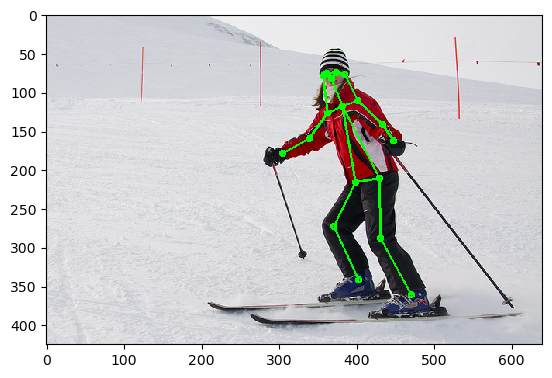

In [37]:
%time
execute_jpeg({'new':'./test-ski.jpg'})

CPU times: user 3 µs, sys: 2 µs, total: 5 µs
Wall time: 9.3 µs


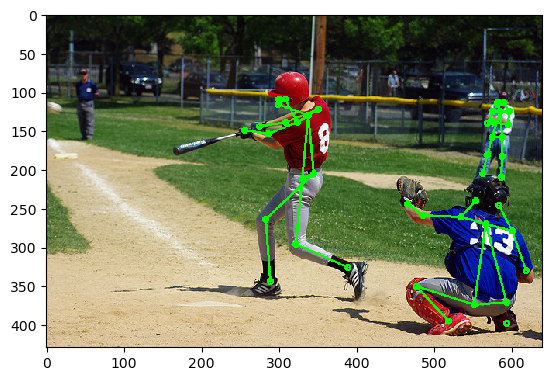

In [39]:
%time
execute_jpeg({'new':'./test-baseball.jpg'})

CPU times: user 3 µs, sys: 2 µs, total: 5 µs
Wall time: 11.2 µs


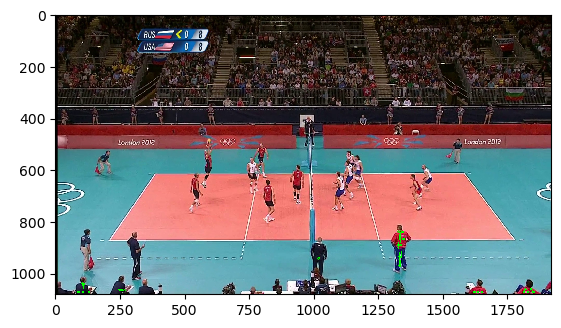

In [40]:
%time
execute_jpeg({'new':'./volley-image.jpg'})

If we call the cell below it will execute the function once on the current camera frame.

In [ ]:
execute({'new': camera.value})

Call the cell below to attach the execution function to the camera's internal value.  This will cause the execute function to be called whenever a new camera frame is received.

In [ ]:
camera.observe(execute, names='value')

Call the cell below to unattach the camera frame callbacks.

In [ ]:
camera.unobserve_all()